<a href="https://colab.research.google.com/github/nikhilnair31/SpectroTune---Genre-Classifier/blob/main/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [3]:
!pip install sounddevice scipy

In [4]:
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initializing

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# Image dimensions
IMG_HEIGHT = 200
IMG_WIDTH = 150
IMG_CHANNELS = 3
BATCH_SIZE = 64
NUM_CLASSES = 10
EPOCHS = 30

# Paths
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Data/spectrogram_images/genres_original"

## Data Loading

In [ ]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = ImageFolder(train_data_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

In [9]:
validation_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
validation_dataset = ImageFolder(train_data_dir, transform=validation_transform)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

## Model Setup and Training

In [10]:
# Model architecture
class Net_Fancy(nn.Module):
    def __init__(self):
        super(Net_Fancy, self).__init__()
        self.conv1 = nn.Conv2d(IMG_CHANNELS, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8), 64)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(16, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.bn2(x)

        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = self.bn3(x)

        x = self.flatten(x)

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)

        x = nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)

        x = nn.functional.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)

        return x

In [11]:
class Net_Simple(nn.Module):
    def __init__(self):
        super(Net_Simple, self).__init__()
        self.conv1 = nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4), 128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.bn2(x)

        x = self.flatten(x)

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.fc2(x)

        return x

In [12]:
class Net_Minimal(nn.Module):
    def __init__(self):
        super(Net_Minimal, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4), NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## Model Training

In [10]:
# Create an instance of the model and move it to the GPU
model = Net_Simple().to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=0.00002)
criterion = nn.CrossEntropyLoss()

# Before the training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [11]:
# Train the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Epoch Time: {epoch_time:.2f} seconds")

Epoch 1/30, Train Loss: 2.2181, Train Accuracy: 0.1906, Validation Loss: 2.1647, Validation Accuracy: 0.2357, Epoch Time: 55.88 seconds
Epoch 2/30, Train Loss: 2.0857, Train Accuracy: 0.2407, Validation Loss: 1.9820, Validation Accuracy: 0.3139, Epoch Time: 13.64 seconds
Epoch 3/30, Train Loss: 2.0384, Train Accuracy: 0.2618, Validation Loss: 1.8735, Validation Accuracy: 0.3480, Epoch Time: 13.78 seconds
Epoch 4/30, Train Loss: 2.0068, Train Accuracy: 0.2758, Validation Loss: 1.8045, Validation Accuracy: 0.3280, Epoch Time: 13.74 seconds
Epoch 5/30, Train Loss: 1.9643, Train Accuracy: 0.2788, Validation Loss: 1.7509, Validation Accuracy: 0.3671, Epoch Time: 13.91 seconds
Epoch 6/30, Train Loss: 1.9403, Train Accuracy: 0.3019, Validation Loss: 1.7682, Validation Accuracy: 0.4203, Epoch Time: 13.79 seconds
Epoch 7/30, Train Loss: 1.9224, Train Accuracy: 0.3200, Validation Loss: 1.7839, Validation Accuracy: 0.3681, Epoch Time: 14.37 seconds
Epoch 8/30, Train Loss: 1.9150, Train Accuracy: 

In [14]:
# Save the trained model
torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/model.pth")

In [15]:
# Model summary
print(f'{"-"*100}\nModel:\n{model}\n{"-"*100}\nTraining completed!')

----------------------------------------------------------------------------------------------------
Model:
Net_Simple(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=118400, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------------------------------------------
Training completed!


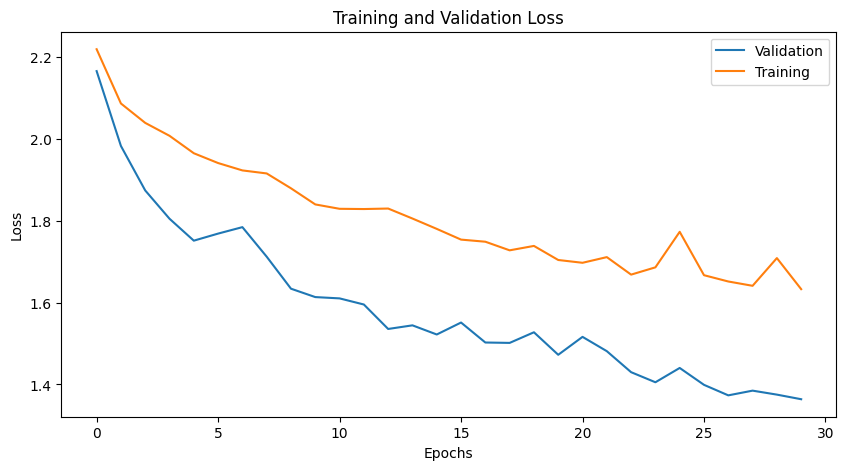

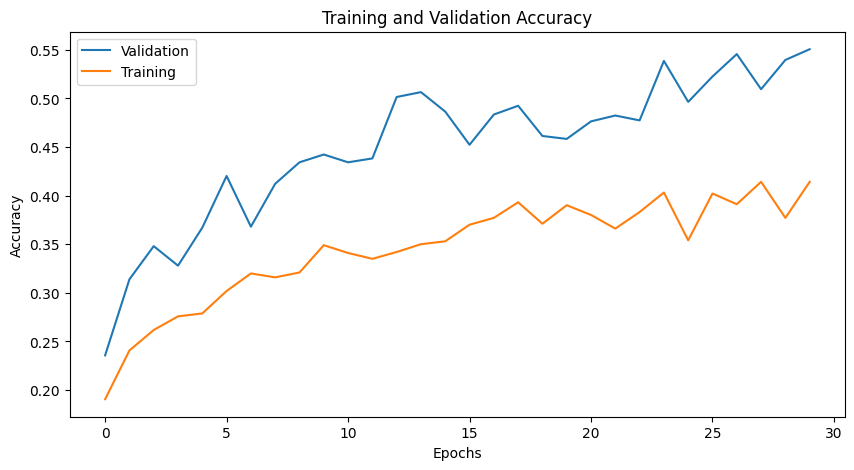

In [16]:
# Plots for training and validation losses
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="Validation")
plt.plot(train_losses, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plots for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies, label="Validation")
plt.plot(train_accuracies, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Results

In [15]:
# Load the trained model
model = Net_Simple()
model.load_state_dict(torch.load(r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/model.pth"))
model.eval()

Net_Simple(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=118400, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

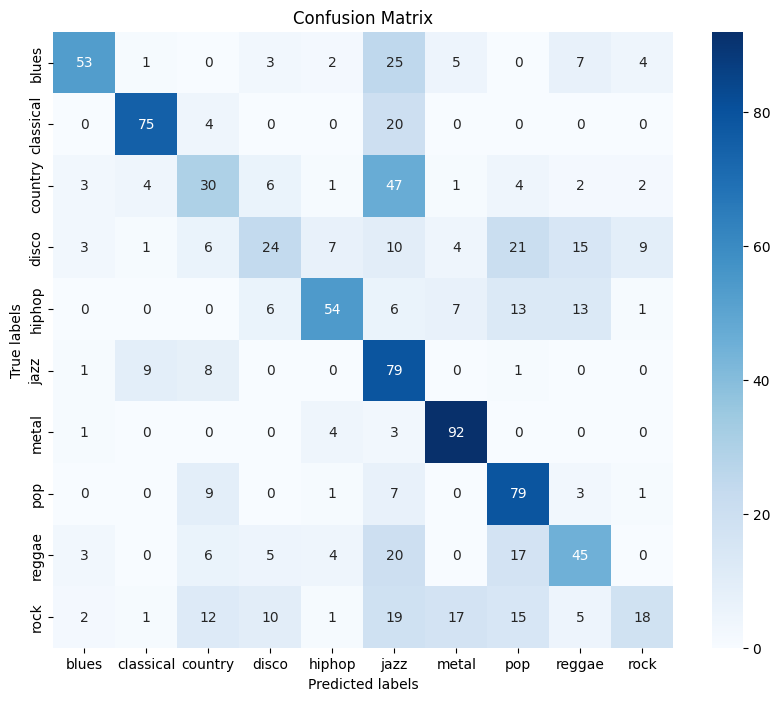

In [30]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Initialize the lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Predict labels for validation dataset
with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Transform predicted_labels and true_labels into class names
predicted_labels = [idx_to_class[label] for label in predicted_labels]
true_labels = [idx_to_class[label] for label in true_labels]

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get list of class names
class_names = list(class_to_idx.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

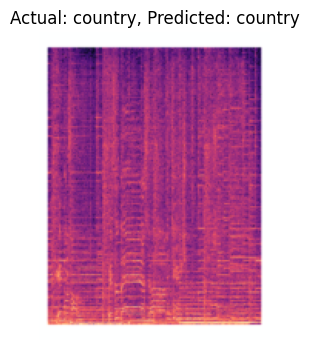

In [36]:
# Get class names
class_names = train_dataset.classes

# Choose a random image from validation dataset
random_idx = random.randint(0, len(validation_dataset)-1)
input_img, actual_label = validation_dataset[random_idx]

# Add a batch dimension
input_img = input_img.unsqueeze(0)

# Move image to GPU
input_img = input_img.to(device)

# Make prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_img)
predicted_label = output.argmax(dim=1).item()

# Get the actual and predicted names
actual_name = class_names[actual_label]
predicted_name = class_names[predicted_label]

# Show the image

# Get mean and std
mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

# Denormalize image
input_img_denormalized = std * input_img[0].cpu().numpy() + mean

# Make sure values are in [0,1] range and transpose
input_img_denormalized = np.clip(input_img_denormalized, 0, 1)
input_img_denormalized = np.transpose(input_img_denormalized, (1, 2, 0))

plt.figure(figsize=(5, 4))
plt.axis('off')
plt.imshow(input_img_denormalized)
plt.title(f"Actual: {actual_name}, Predicted: {predicted_name}")
plt.show()


## Testing

In [21]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import write
import io

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new TextDecoder('utf-8').decode(blob)
const record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(await blob.arrayBuffer())
    resolve(text)
  }
  recorder.stop()
})
"""
def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])

  process = (b'RIFF\x00\x00\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00' +
             b'\x80\xbb\x00\x00\x00\x77\x01\x00\x02\x00\x10\x00data\x00\x00\x00\x00')
  start = b.find(process)
  b = b[start:]

  fp = io.BytesIO(b)
  return np.memmap(fp, dtype=np.int16)

# Recording 10 seconds of audio
audio = record(10)

# Save it as .wav file
write('audio.wav', 16000, audio)

<IPython.core.display.Javascript object>

MessageError: ignored